In [1]:
!pip install causalml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: Cython
    Found existing installation: Cython 3.0.11
    Uninstalling Cython-3.0.11:
      Successfully uninstalle

# Well-being Program Causal Analysis

#### Setup and Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from causalml.inference.meta import (
    BaseSClassifier, BaseTClassifier, BaseXClassifier, BaseRClassifier
)
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import get_cumgain, plot_gain
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style - using a more basic style setup
plt.style.use('default')
sns.set_theme()  # This is the newer way to set seaborn's style
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

In [32]:
class WellbeingCausalAnalysis:
    def __init__(self, seed=42):
        """Initialize the causal analysis framework"""
        self.seed = seed
        np.random.seed(seed)
        self.metrics = ['productivity', 'absenteeism', 'customer_satisfaction', 'operational_efficiency']

    def generate_synthetic_data(self, n_samples=1000):
        """Generate synthetic workplace data with treatment effects"""
        # Employee characteristics
        departments = ['Sales', 'IT', 'Operations', 'HR', 'Finance']
        age = np.random.normal(35, 8, n_samples)
        tenure = np.random.normal(5, 3, n_samples)
        dept = np.random.choice(departments, n_samples)

        # Generate confounders
        stress_level = np.random.normal(7, 2, n_samples)
        workload = np.random.normal(75, 15, n_samples)

        # Treatment assignment (well-being program participation)
        propensity = 1 / (1 + np.exp(-(0.3*stress_level + 0.2*workload - 0.1*age)/5))
        treatment = np.random.binomial(1, propensity)

        # Generate outcomes with treatment effects
        base_productivity = 75 + 0.2*age + 0.5*tenure - 0.3*stress_level
        base_absenteeism = 5 + 0.1*stress_level + 0.05*workload
        base_satisfaction = 70 + 0.1*age - 0.4*stress_level
        base_efficiency = 80 + 0.3*tenure - 0.2*workload

        # Treatment effects
        productivity = base_productivity + treatment * (5 + 0.1*stress_level)
        absenteeism = base_absenteeism - treatment * (1 + 0.05*stress_level)
        satisfaction = base_satisfaction + treatment * (3 + 0.1*workload)
        efficiency = base_efficiency + treatment * (4 + 0.1*tenure)

        # Create DataFrame
        data = pd.DataFrame({
            'age': age,
            'tenure': tenure,
            'department': dept,
            'stress_level': stress_level,
            'workload': workload,
            'treatment': treatment,
            'productivity': productivity + np.random.normal(0, 2, n_samples),
            'absenteeism': absenteeism + np.random.normal(0, 0.5, n_samples),
            'customer_satisfaction': satisfaction + np.random.normal(0, 3, n_samples),
            'operational_efficiency': efficiency + np.random.normal(0, 2, n_samples)
        })

        return data

    def prepare_features(self, data):
        """Prepare features for modeling"""
        # Encode categorical variables
        le = LabelEncoder()
        data_processed = data.copy()
        if 'department' in data.columns:
            data_processed['department'] = le.fit_transform(data['department'])

        # Separate features, treatment, and outcomes
        feature_cols = ['age', 'tenure', 'department', 'stress_level', 'workload']
        X = data_processed[feature_cols]

        # Scale features
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

        treatment = data_processed['treatment']
        outcomes = data_processed[self.metrics]

        return X_scaled, treatment, outcomes

    def train_models(self, X, treatment, outcome):
        """Train multiple causal inference models for continuous outcomes"""
        from causalml.inference.meta import (
            BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
        )

        # Initialize models with regressors
        models = {
            'S-Learner': BaseSRegressor(
                learner=LGBMRegressor(random_state=self.seed, force_col_wise=True, verbose = -1)
            ),
            'T-Learner': BaseTRegressor(
                learner=LGBMRegressor(random_state=self.seed, force_col_wise=True, verbose = -1)
            ),
            'X-Learner': BaseXRegressor(
                learner=LGBMRegressor(random_state=self.seed, force_col_wise=True, verbose = -1),
                control_outcome_learner=LGBMRegressor(random_state=self.seed, force_col_wise=True, verbose = -1),
                treatment_outcome_learner=LGBMRegressor(random_state=self.seed, force_col_wise=True, verbose = -1),
                control_effect_learner=LGBMRegressor(random_state=self.seed, force_col_wise=True, verbose = -1),
                treatment_effect_learner=LGBMRegressor(random_state=self.seed, force_col_wise=True, verbose = -1)
            ),
            'R-Learner': BaseRRegressor(
                outcome_learner=LGBMRegressor(random_state=self.seed, force_col_wise=True, verbose = -1),
                effect_learner=LGBMRegressor(random_state=self.seed, force_col_wise=True, verbose = -1)
            )
        }

        # Calculate propensity scores
        prop_model = LogisticRegression(random_state=self.seed)
        propensity_scores = prop_model.fit(X, treatment).predict_proba(X)[:, 1]

        # Train models and get estimates
        results = {}
        for name, model in models.items():
            if name in ['X-Learner', 'R-Learner']:
                ate = model.estimate_ate(X, treatment, outcome, p=propensity_scores)
                ite = model.fit_predict(X, treatment, outcome, p=propensity_scores)
            else:
                ate = model.estimate_ate(X, treatment, outcome)
                ite = model.fit_predict(X, treatment, outcome)

            results[name] = {
                'model': model,
                'ate': ate[0],
                'ite': ite
            }

        return results

    def analyze_heterogeneity(self, X, results, feature_name, n_bins=4):
        """Analyze treatment effect heterogeneity"""
        plt.figure(figsize=(12, 6))

        # Create bins for the feature
        if X[feature_name].dtype in [np.float64, np.int64]:
            bins = pd.qcut(X[feature_name], q=n_bins, duplicates='drop')
        else:
            bins = X[feature_name]

        # Calculate mean effects by bin for each model
        for model_name, model_results in results.items():
            mean_effects = pd.DataFrame({
                'bin': bins,
                'effect': model_results['ite'].ravel()
            }).groupby('bin')['effect'].mean()

            plt.plot(range(len(mean_effects)), mean_effects.values,
                    marker='o', label=model_name)

        plt.title(f'Treatment Effect Heterogeneity by {feature_name}')
        plt.xlabel(f'{feature_name} bins')
        plt.ylabel('Average Treatment Effect')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    def plot_uplift_curves(self, y_true, treatment, results):
        """Plot uplift curves for all models"""
        plt.figure(figsize=(10, 6))

        for model_name, model_results in results.items():
            # Calculate uplift curve
            treatment_effects = model_results['ite'].ravel()

            # Sort by predicted effect
            sorted_idx = np.argsort(-treatment_effects)
            sorted_treatment = treatment.iloc[sorted_idx]
            sorted_outcome = y_true.iloc[sorted_idx]

            # Calculate cumulative gains
            cum_gains = np.cumsum(sorted_outcome * sorted_treatment) / \
                       (np.cumsum(sorted_treatment) + 1e-8) - \
                       np.cumsum(sorted_outcome * (1-sorted_treatment)) / \
                       (np.cumsum(1-sorted_treatment) + 1e-8)

            plt.plot(range(len(cum_gains)), cum_gains, label=model_name)

        plt.title('Uplift Curves by Model')
        plt.xlabel('Population Percentage')
        plt.ylabel('Cumulative Gain')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()


Analyzing productivity:

Average Treatment Effects:
S-Learner: 5.780
T-Learner: 5.803
X-Learner: 5.986
R-Learner: 4.715

Analyzing treatment effect heterogeneity...


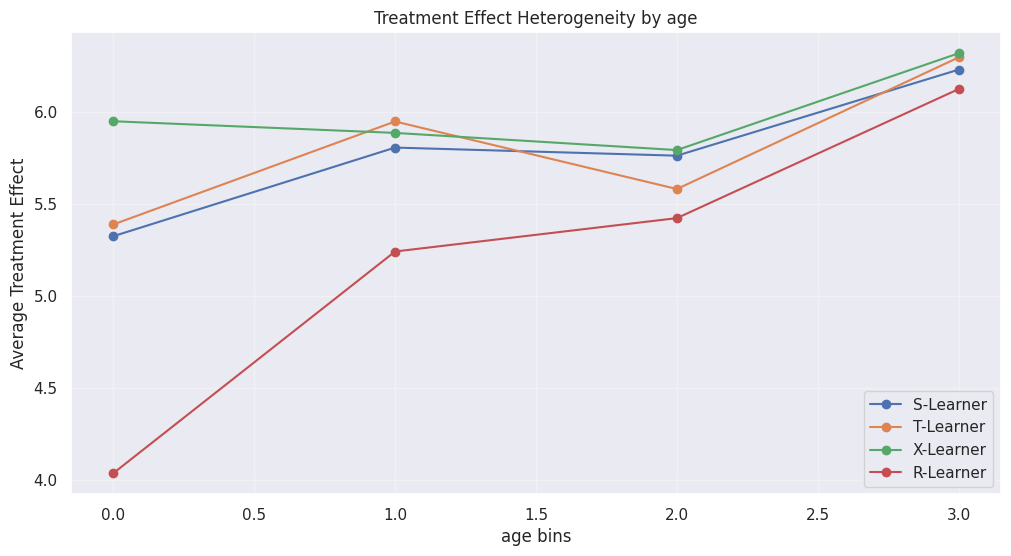

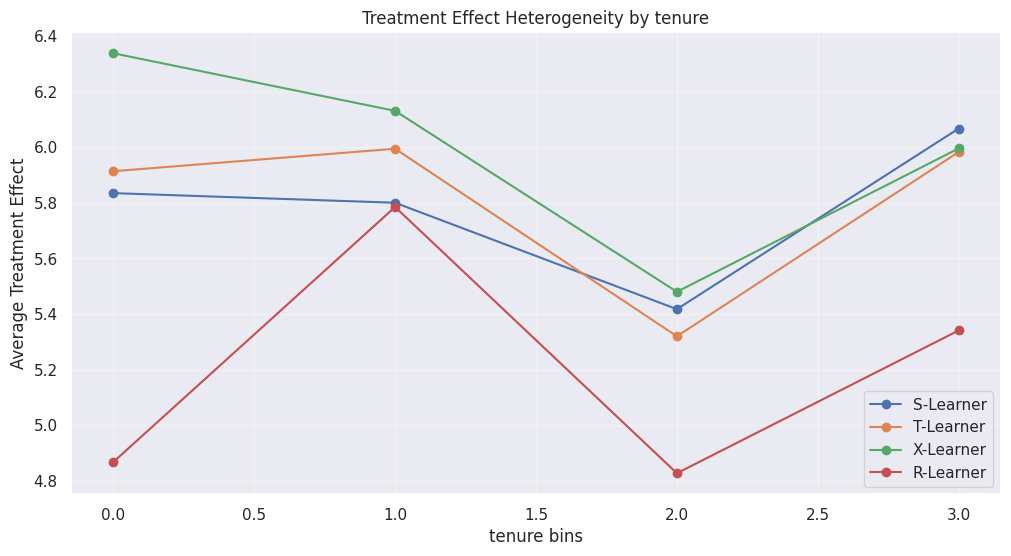

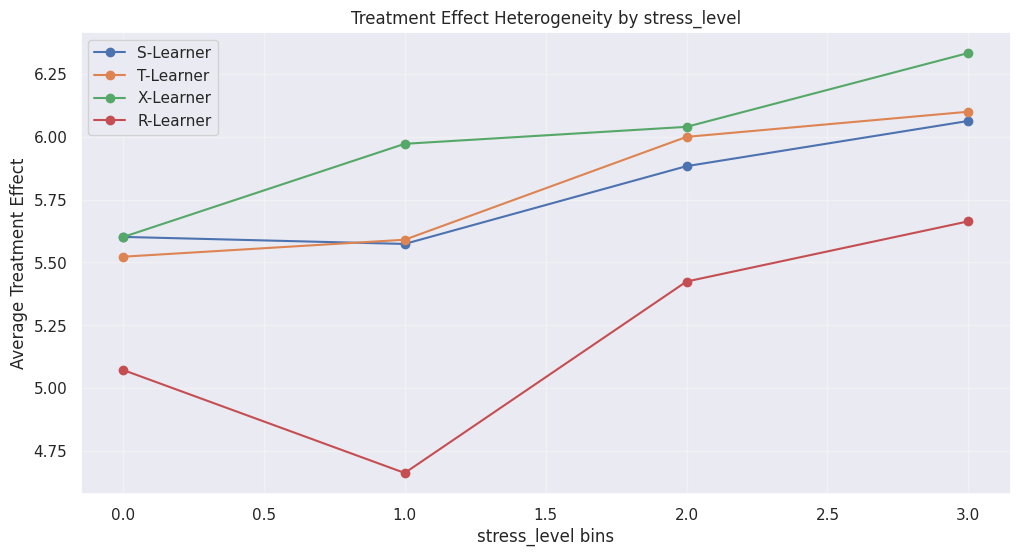

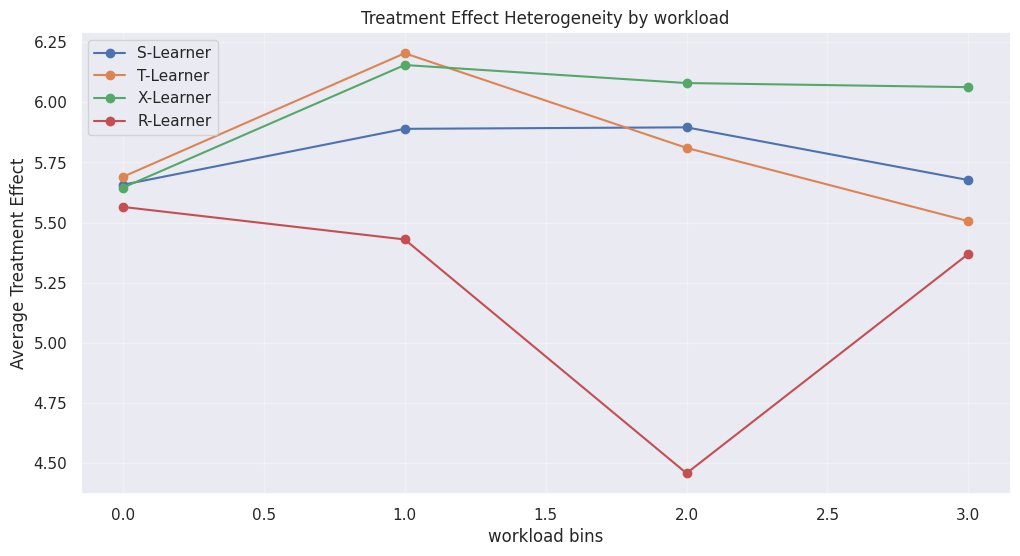


Generating uplift curves...


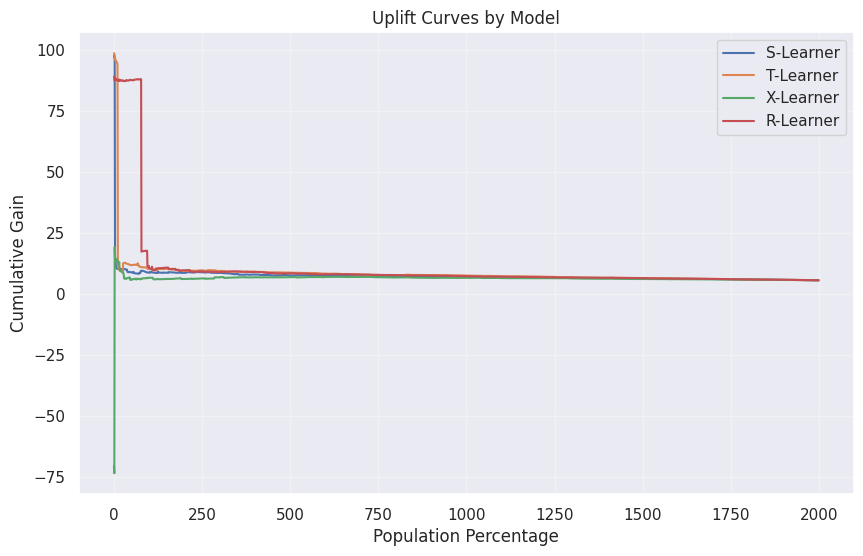


Analyzing absenteeism:

Average Treatment Effects:
S-Learner: -1.278
T-Learner: -1.350
X-Learner: -1.430
R-Learner: -1.328

Analyzing treatment effect heterogeneity...


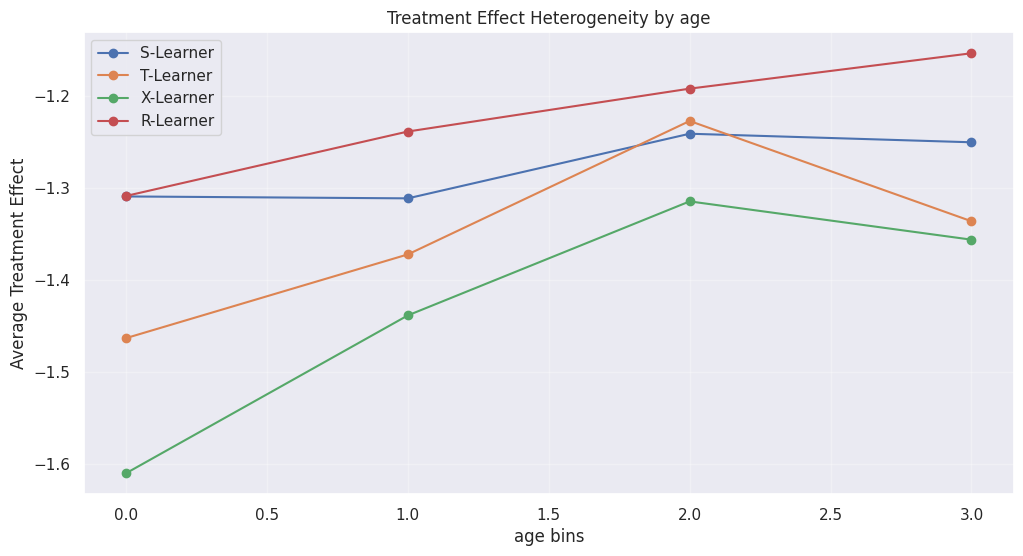

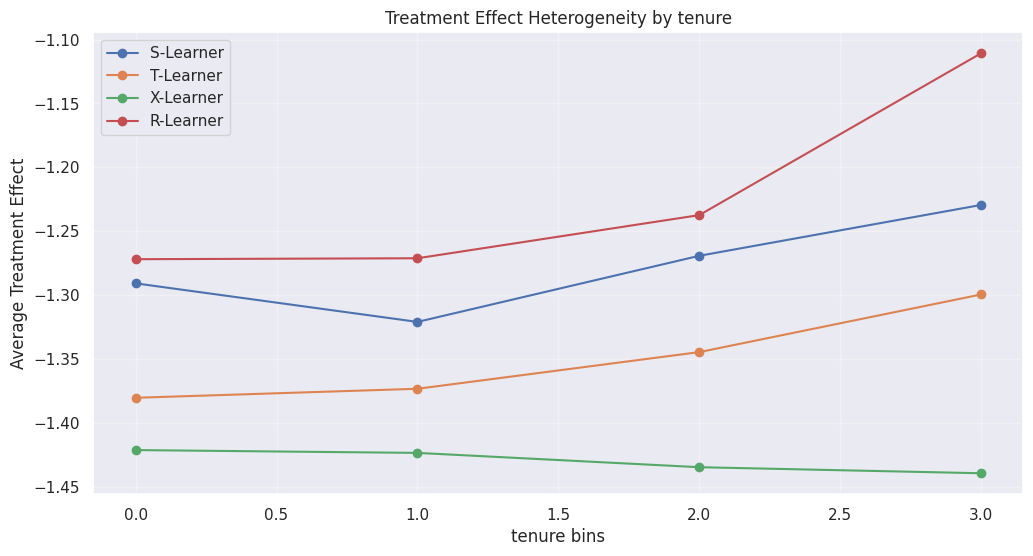

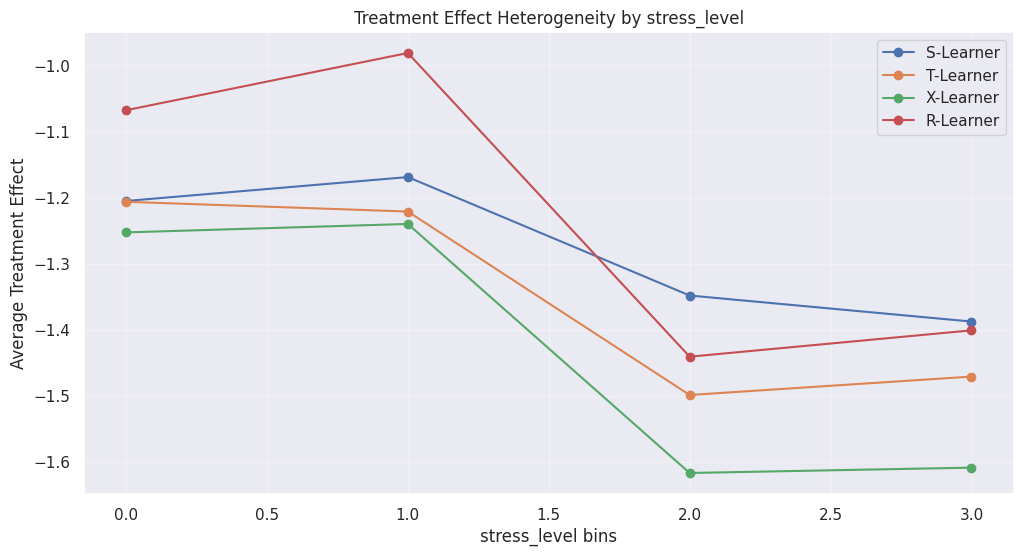

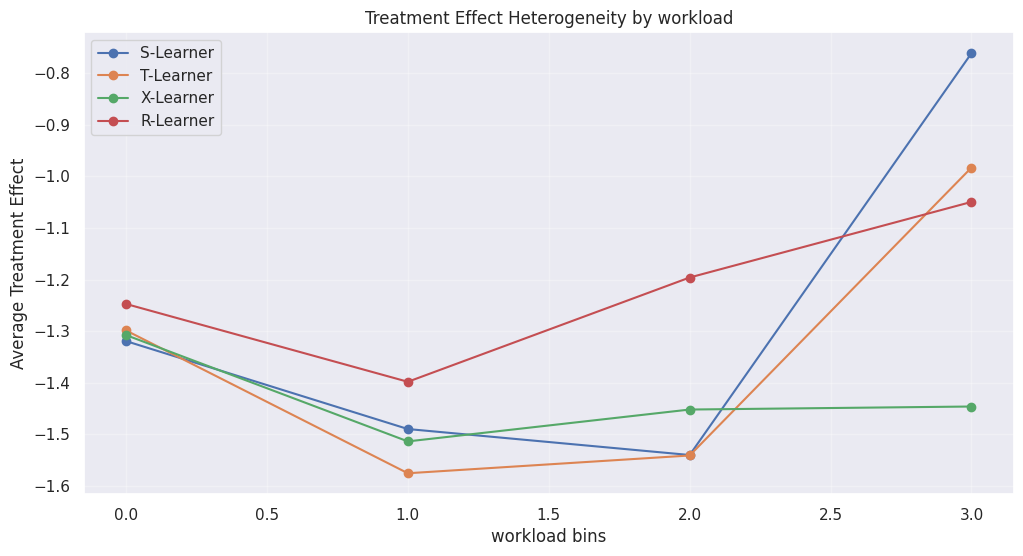


Generating uplift curves...


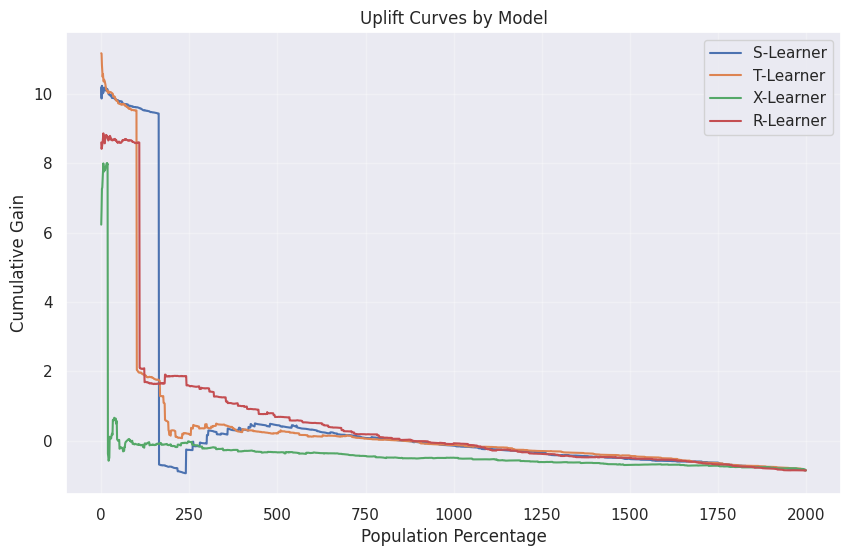


Analyzing customer_satisfaction:

Average Treatment Effects:
S-Learner: 10.703
T-Learner: 10.831
X-Learner: 10.844
R-Learner: 9.217

Analyzing treatment effect heterogeneity...


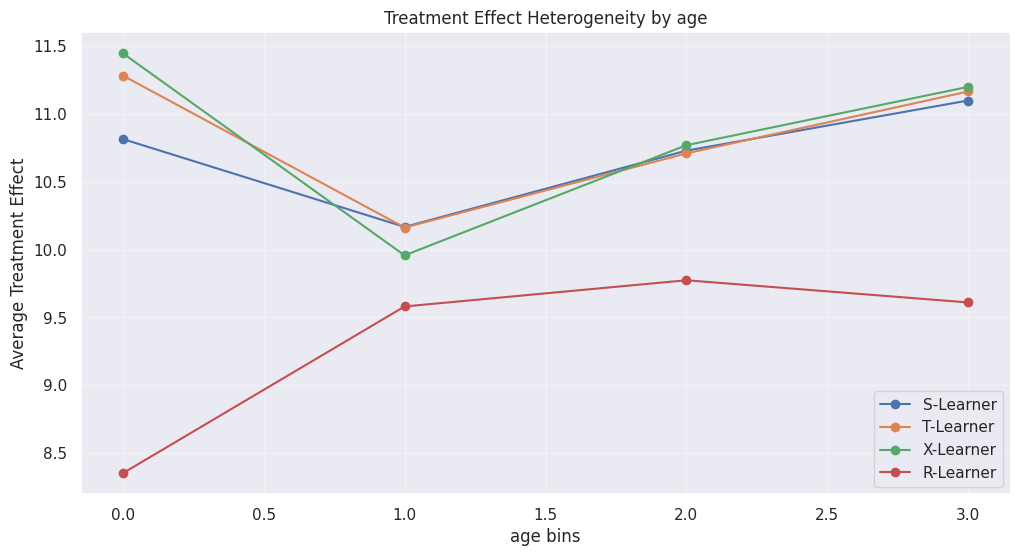

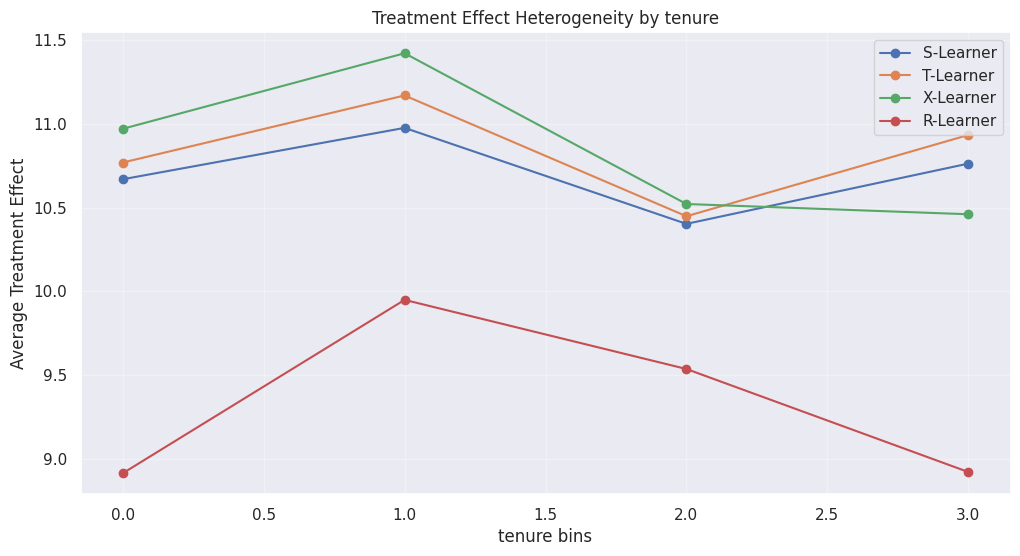

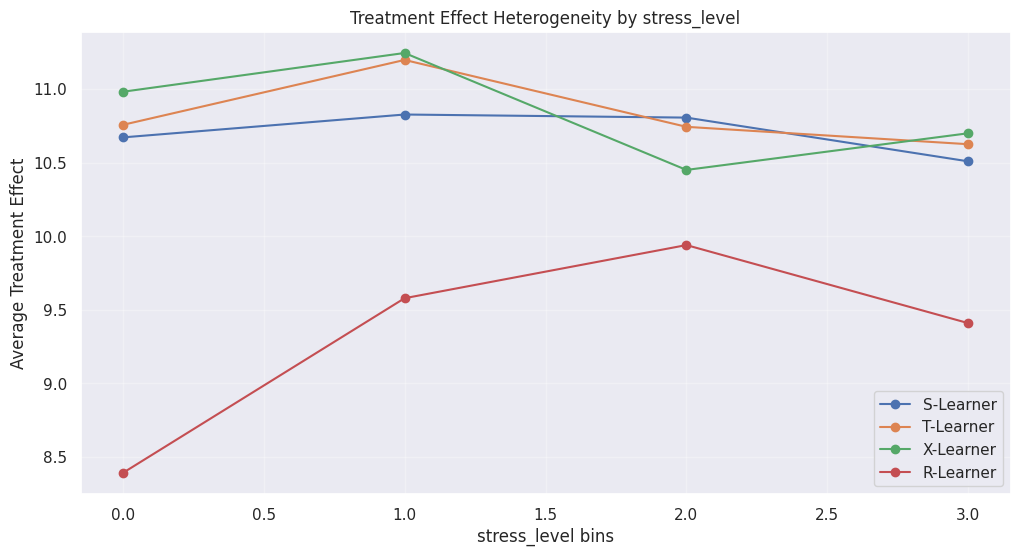

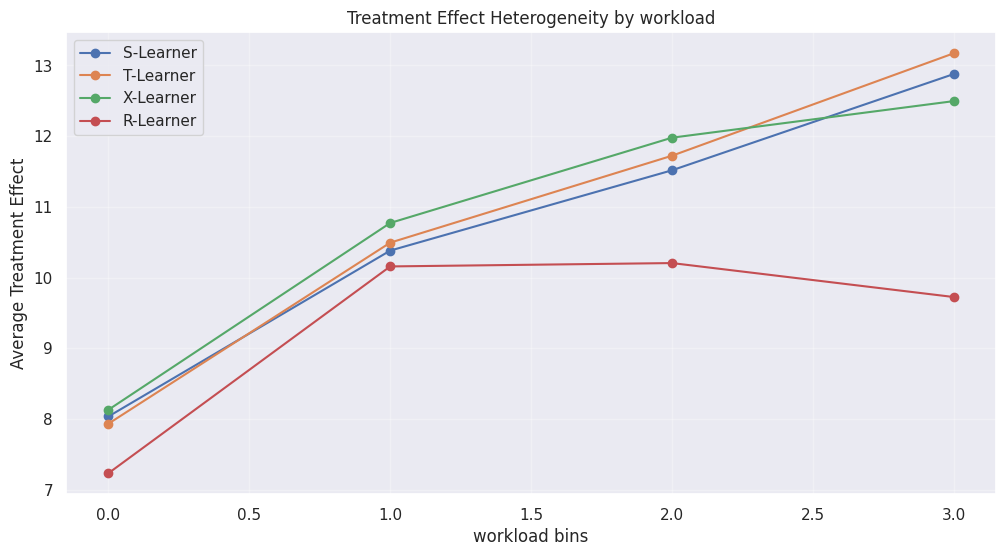


Generating uplift curves...


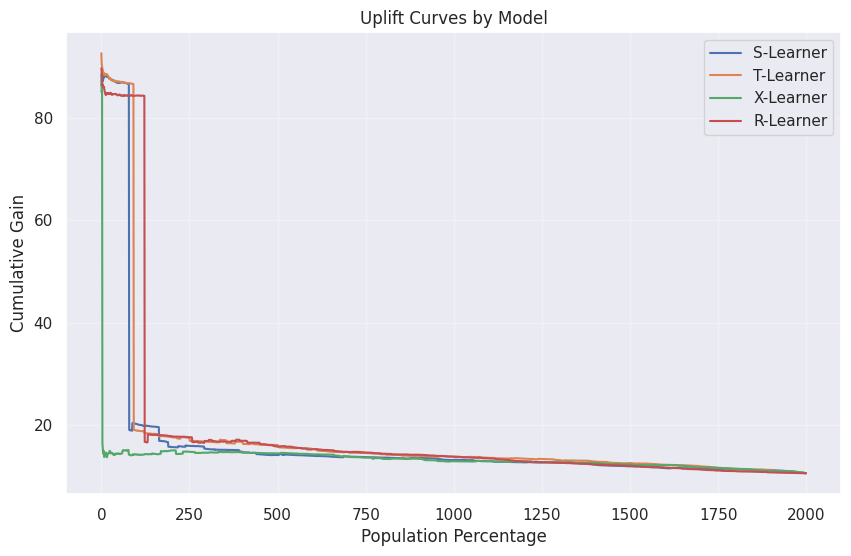


Analyzing operational_efficiency:

Average Treatment Effects:
S-Learner: 3.849
T-Learner: 3.977
X-Learner: 4.323
R-Learner: 4.024

Analyzing treatment effect heterogeneity...


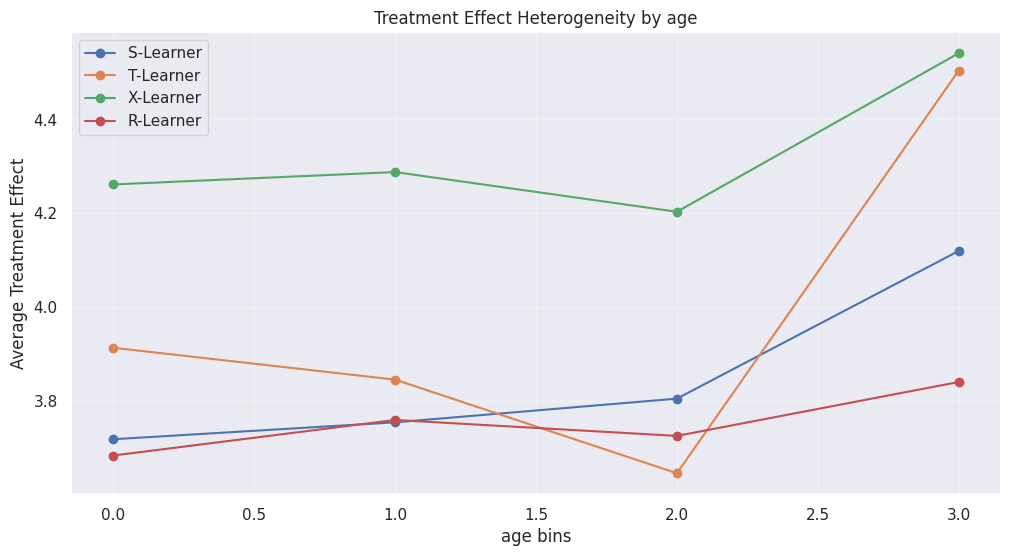

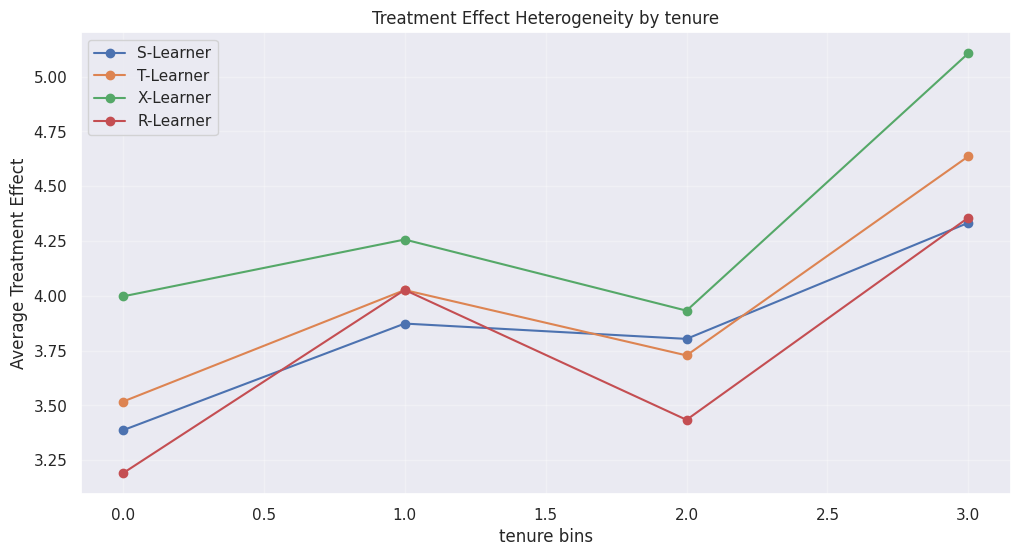

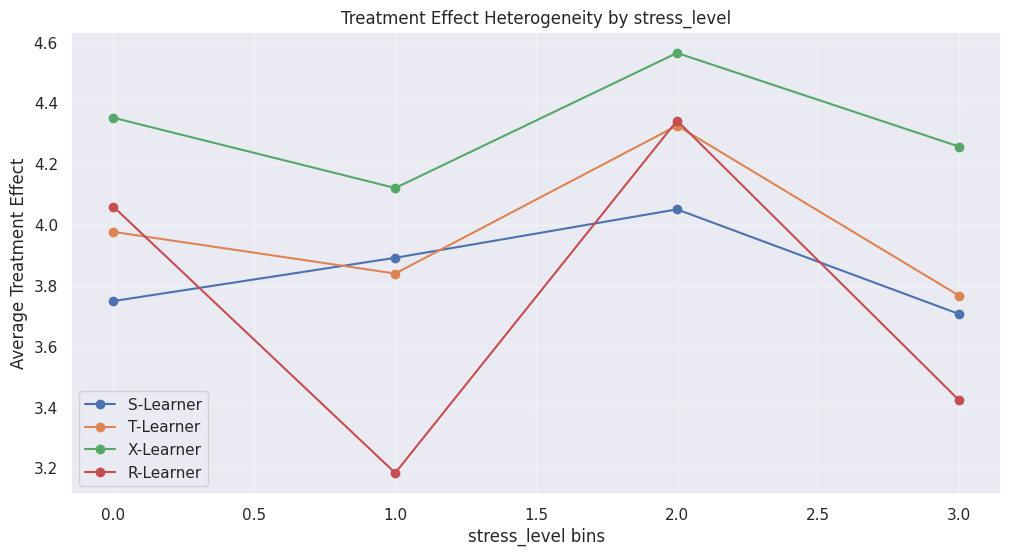

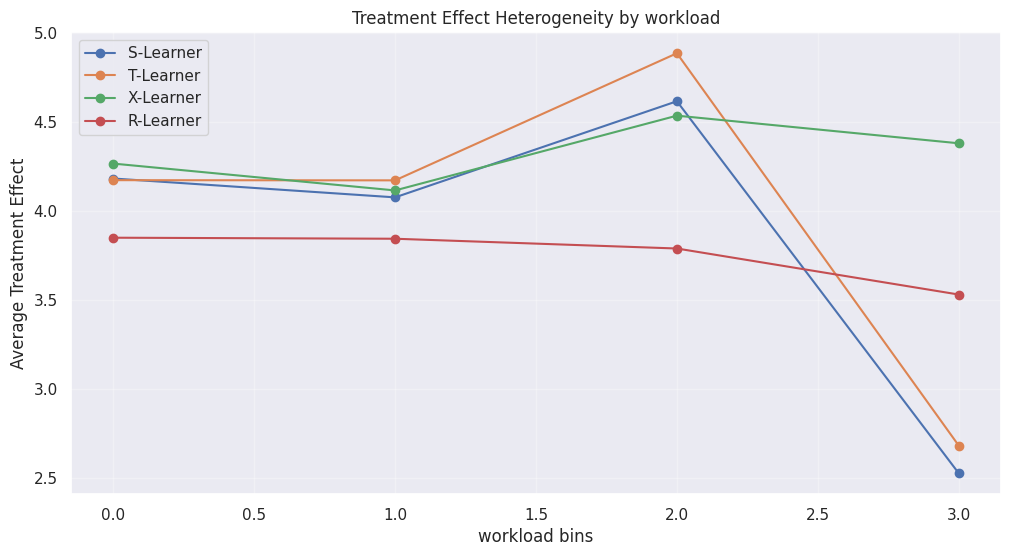


Generating uplift curves...


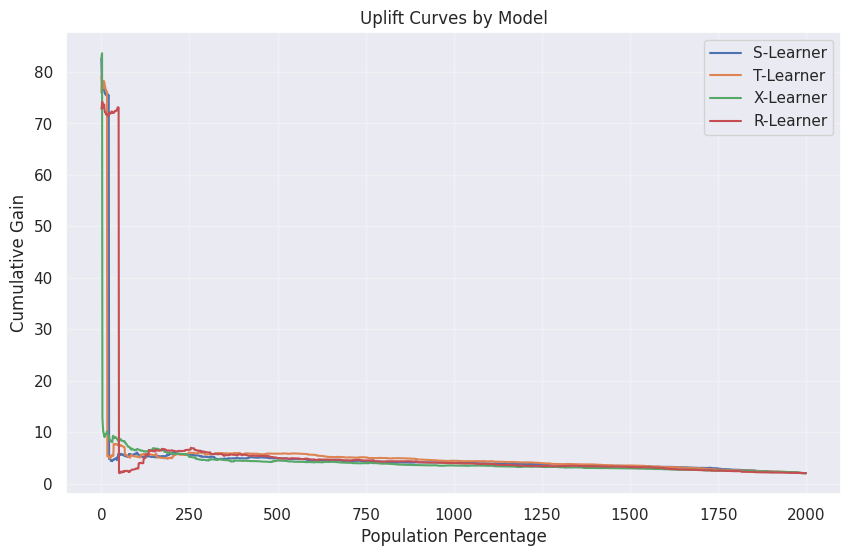

In [33]:
# Initialize analysis
analysis = WellbeingCausalAnalysis(seed=42)

# Generate synthetic data
data = analysis.generate_synthetic_data(n_samples=2000)

# Prepare features
X, treatment, outcomes = analysis.prepare_features(data)

# Analyze each metric
for metric in analysis.metrics:
    print(f"\nAnalyzing {metric}:")

    # Train models
    results = analysis.train_models(X, treatment, outcomes[metric])

    # Print ATE estimates
    print("\nAverage Treatment Effects:")
    for model_name, model_results in results.items():
        # Convert numpy array to float before formatting
        ate_value = float(model_results['ate']) if isinstance(model_results['ate'], np.ndarray) else model_results['ate']
        print(f"{model_name}: {ate_value:.3f}")

    # Plot heterogeneity analysis
    print("\nAnalyzing treatment effect heterogeneity...")
    for feature in ['age', 'tenure', 'stress_level', 'workload']:
        analysis.analyze_heterogeneity(X, results, feature)

    # Plot uplift curves
    print("\nGenerating uplift curves...")
    analysis.plot_uplift_curves(outcomes[metric], treatment, results)